In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emotion-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4123094%2F7143293%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240315%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240315T224725Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04dfe4566cbfc8e35d965c4e75ced06f2bad80557e53d32dbada9a61d0b5cc32968a0df5a988cb0d8ea55acc2db0c143ba1d5228b4c9ed0081170322cfa227bfa78edeff97bad82fd69a70f17d0b18101977782bdc6fed12fb8b9d3098fe27a892871c3c9738dcd035d0e2869ba3fc45afd54979827633af544eaa7bb25ba8b3e15d0eb087daf6051d07bd1def7431ccb0a85776480e2699b7e1258ed51cb777c100dac25baef569f72f3500a99bc8314df07f88168bdb728dd2996277c4e2b7f6540a03e4f8a0af8ff547ef067ebd80516879f2fcc7bba3dcdf4c22fb5e1b65792ba6157c3a30acba1c508b23feabef77660e808b531702ffae8e61fe16c722'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2126237709 bytes downloaded
Downloaded and uncompressed: emotion-recognition-dataset
Data source import complete.


In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow 2>/dev/null

In [ ]:
# Importing necessary libraries and modules
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

In [ ]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
image_dict = {}

from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []

for file in tqdm(sorted((Path('/kaggle/input/emotion-recognition-dataset/dataset/').glob('*/*.*')))):
    file_names.append(str(file))
    label = str(file).split('/')[-2]
    labels.append(label)

print(len(file_names), len(labels), len(set(labels)))

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

100%|██████████| 15453/15453 [00:00<00:00, 191931.74it/s]

15453 15453 6


In [ ]:
df['label'].unique()

array(['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'],
      dtype=object)

In [ ]:
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(24162, 2)


In [ ]:
df['label'].value_counts().head(50)
dataset = Dataset.from_pandas(df).cast_column("image", Image())

In [ ]:
labels_subset = list(df['label'])[:5]

print(labels_subset)

['Ahegao', 'Ahegao', 'Ahegao', 'Ahegao', 'Ahegao']


In [ ]:
labels_list = sorted(list(set(df['label'])))

label2id, id2label = dict(), dict()


for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Ahegao', 1: 'Angry', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'} 

Mapping of Labels to IDs: {'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.1, shuffle=True, stratify_by_column="label")

train_data = dataset['train']

test_data = dataset['test']

Map:   0%|          | 0/24162 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/24162 [00:00<?, ? examples/s]

In [ ]:
model_str = 'face_emotions_image_detection' #'google/vit-base-patch16-224-in21k'


processor = ViTImageProcessor.from_pretrained(model_str)


image_mean, image_std = processor.image_mean, processor.image_std


size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        RandomHorizontalFlip(0.5),
        ToTensor(),
        normalize
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Size:  224


In [ ]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):

    pixel_values = torch.stack([example["pixel_values"] for example in examples])


    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/871 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.80327


In [ ]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):

    predictions = eval_pred.predictions

    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)

    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"

model_name = "face_emotions_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 3

args = TrainingArguments(
    output_dir=model_name,

    logging_dir='./logs',

    evaluation_strategy="epoch",

    learning_rate=5e-7,

    per_device_train_batch_size=64,

    per_device_eval_batch_size=32,

    num_train_epochs=num_train_epochs,

    weight_decay=0.02,

    warmup_steps=50,

    remove_unused_columns=False,

    save_strategy='epoch',

    load_best_model_at_end=True,

    save_total_limit=1,

)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
# Evaluate the pre-training model's performance on a test dataset.

trainer.evaluate()

{'eval_loss': 0.8212005496025085,
 'eval_accuracy': 0.7554820024824163,
 'eval_runtime': 62.6844,
 'eval_samples_per_second': 38.558,
 'eval_steps_per_second': 1.212}

In [ ]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.807421,0.758378
2,0.727700,0.799667,0.759619
3,0.717300,0.796715,0.758378


TrainOutput(global_step=1020, training_loss=0.722238312515558, metrics={'train_runtime': 2736.2908, 'train_samples_per_second': 23.841, 'train_steps_per_second': 0.373, 'total_flos': 5.05537117478185e+18, 'train_loss': 0.722238312515558, 'epoch': 3.0})

In [ ]:
# Evaluate the post-training model's performance on the validation or test dataset.

trainer.evaluate()

{'eval_loss': 0.7967149615287781,
 'eval_accuracy': 0.7583781547372777,
 'eval_runtime': 44.6692,
 'eval_samples_per_second': 54.109,
 'eval_steps_per_second': 1.701,
 'epoch': 3.0}

In [ ]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.7967149615287781, 'test_accuracy': 0.7583781547372777, 'test_runtime': 44.2048, 'test_samples_per_second': 54.677, 'test_steps_per_second': 1.719}


Accuracy: 0.7584
F1 Score: 0.7527


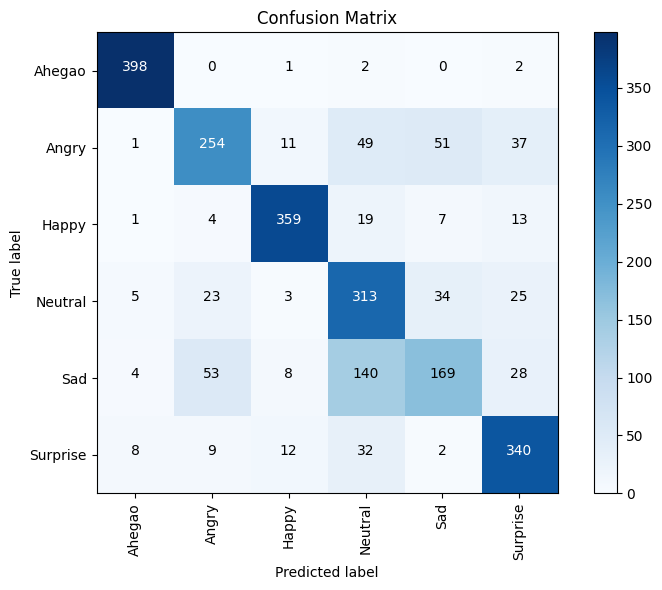


Classification report:

              precision    recall  f1-score   support

      Ahegao     0.9544    0.9876    0.9707       403
       Angry     0.7405    0.6303    0.6810       403
       Happy     0.9112    0.8908    0.9009       403
     Neutral     0.5640    0.7767    0.6534       403
         Sad     0.6426    0.4204    0.5083       402
    Surprise     0.7640    0.8437    0.8019       403

    accuracy                         0.7584      2417
   macro avg     0.7628    0.7582    0.7527      2417
weighted avg     0.7628    0.7584    0.7528      2417



In [ ]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """

    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')


    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 250:

    cm = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
# Save the trained model: This line of code is responsible for saving the model
trainer.save_model('/content/drive/MyDrive/CharbelMATTAR_LU_WebDev/Project/Model')